In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

In [2]:
import os

if os.getcwd().endswith('notebooks'):
    os.chdir('..')
    print('Changed directory to', os.getcwd())

Changed directory to /morphoml


# Load data

In [3]:
from morphoml.dataprep import load_hdf5

npix = 69
transfer_learn = False  # Start from pretrained (imagenet) CNN?
imgs, names = load_hdf5(f'./data/images/processed_scauto_{npix}.h5')
print('Images shape:', imgs.shape, '; Names shape:', names.shape)
names[:5]

Images shape: (73627, 69, 69) ; Names shape: (73627,)


array([1237648722296897660, 1237667293729849467, 1237667430092570789,
       1237668299283824738, 1237664818211192894])

In [4]:
test_labels = np.loadtxt('./data/split/test_labels.txt', dtype=np.int)
val_labels = np.loadtxt('./data/split/val_labels.txt', dtype=np.int)
train_labels = np.loadtxt('./data/split/train_labels.txt', dtype=np.int)
print('(max) train size:', len(train_labels), ', val size:', len(val_labels),
      ', test size:', len(test_labels))
test_labels[:5]

(max) train size: 66127 , val size: 2500 , test size: 5000


array([1237667447275847690, 1237674604290441495, 1237661950807703794,
       1237665025446379636, 1237648722833965080])

In [5]:
n_train = 1000
test_idx = np.array([np.where(names[:] == test_labels[i])[0][0] for i in range(len(test_labels))])
val_idx = np.array([np.where(names[:] == val_labels[i])[0][0] for i in range(len(val_labels))])
train_idx = np.array([np.where(names[:] == train_labels[i])[0][0] for i in range(n_train)])
print(test_idx.shape, train_idx.shape)
test_idx[:5]

(5000,) (1000,)


array([42299, 64373, 41618, 33694, 25761])

In [6]:
def create_x(idx):
    return np.expand_dims(np.array(imgs)[idx, ...].copy(), axis=-1)

# x_train is in same order as train_labels, x_test same order as test_labels
x_train, x_val, x_test = create_x(train_idx), create_x(val_idx), create_x(test_idx)
print(x_train.shape, x_val.shape, x_test.shape)

(1000, 69, 69, 1) (2500, 69, 69, 1) (5000, 69, 69, 1)


In [7]:
df_meta = pd.read_csv('./data/metadata/metadata_valid_morphid.tsv',
                      sep='\t', index_col=0)
print(df_meta.shape)
df_meta.head()

(73627, 30)


,RA,DEC,D25,redshift,GalSize_kpc,D_Mpc,d_pix_kpc,reduced_chi_square,logM_bayes,logM_bayes_err,...,ML_zibetti,RA_leda,DEC_leda,D25_leda,R25_leda,pa_leda,id_gz1,dist_gz1,id_gz2,dist_gz2
SDSS_ID,,,,,,,,,,,,,,,,,,,,,
1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,3.980811,10.328326,0.057643,...,2.553861,231.318646,41.346012,0.516416,4.677351,52.77,552094,0.000016,131054,0.191547
1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.537818,9.834362,0.037180,...,1.054716,236.009916,39.288303,0.441570,2.897344,131.08,572069,0.000104,177157,0.094953
1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.280960,9.851568,0.057156,...,0.805557,237.494992,9.278609,0.629506,1.312200,155.89,577778,0.000041,37238,0.000052
1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.192938,10.439780,0.044860,...,1.775870,242.008785,36.053987,0.557186,1.315225,63.55,596382,0.000021,76320,0.000036
1237662474235085097,251.31645,25.60003,0.512861,0.0681,43.540800,291.857134,0.565985,1.540025,9.999021,0.040437,...,1.205651,251.316496,25.600029,0.510505,3.539973,42.81,624773,0.000070,62784,0.079806


In [8]:
def create_y(labels):
    return np.log10(df_meta.loc[labels, 'ML_bayes'])
y_train, y_val, y_test = create_y(train_labels[:n_train]), create_y(val_labels), create_y(test_labels)
print(y_train.shape, y_val.shape, y_test.shape)
y_train.head()

(1000,) (2500,) (5000,)


SDSS_ID
1237665428637745298    0.437492
1237657772313215265    0.431814
1237662499463758003   -0.197632
1237651212286820625    0.390644
1237661064941142771   -0.527936
Name: ML_bayes, dtype: float64

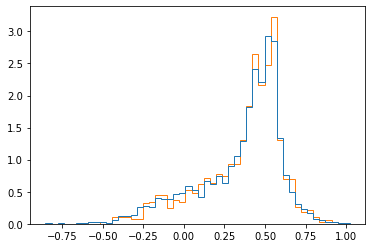

In [9]:
plt.hist([y_test.values.flatten(), y_train.values.flatten()], 50, 
         histtype='step', density=True);

# Dataframe for recording model performance

In [10]:
columns = ['npix', 'ntrain', 'nlayer', 'activation', 'dropout', 'batchnorm',
           'optimizer', 'test_RMSLE', 'test_logR2', 'val_RMSLE', 'val_logR2',
           'train_RMSLE', 'train_logR2', 'architecture']
df_results = pd.DataFrame(columns=columns)

In [11]:
filename = './data/performance/results.tsv'

In [151]:
# Saving
df_results.to_csv(filename, sep='\t')

In [56]:
# Loading
df_results = pd.read_csv(filename, sep='\t', index_col=0)
print(df_results.shape)
df_results.head()

(0, 9)


,npix,ntrain,nlayer,batchnorm,test_RMSLE,test_logR2,train_RMSLE,train_logR2,architecture


# Train and record

Try different architectures and record performance.

In [12]:
from tensorflow.keras import layers

activation = 'relu'
use_dropout = False
use_bn = False

cnn = tf.keras.models.Sequential()
cnn.add(layers.Conv2D(32, (5, 5), activation=activation, input_shape=(npix, npix, 1)))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
if use_dropout:
    cnn.add(layers.Dropout(0.25))
if use_bn:
    cnn.add(layers.BatchNormalization())
cnn.add(layers.Conv2D(64, (4, 4), activation=activation))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
if use_dropout:
    cnn.add(layers.Dropout(0.25))
if use_bn:
    cnn.add(layers.BatchNormalization())
cnn.add(layers.Conv2D(128, (3, 3), activation=activation))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
if use_dropout:
    cnn.add(layers.Dropout(0.25))
if use_bn:
    cnn.add(layers.BatchNormalization())
cnn.add(layers.Conv2D(128, (3, 3), activation=activation))
cnn.add(layers.GlobalMaxPooling2D())
cnn.add(layers.Dense(512, activation=activation))
cnn.add(layers.Dense(1, name='output'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 65, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         1

In [13]:
optimizer = 'nadam'
cnn.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val.values))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test.values))
train_dataset

<TensorSliceDataset shapes: ((69, 69, 1), ()), types: (tf.float32, tf.float64)>

In [15]:
batch_size = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE

def convert(image, label):
    # Cast and normalize the image to [0,1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def augment(image, label):
    add_pix = 10
    image, label = convert(image, label)
    image = image + 1  # to [0, 2], since it automatically pads with zeros
    image = tf.image.resize_with_crop_or_pad(image, npix + add_pix, npix + add_pix) # Add padding
    image = tf.image.random_crop(image, size=[npix, npix, 1]) # Random crop back
    image = image - 1
    # Random angle for each image (not necessary)
#     random_angles = tf.random.uniform((tf.shape(image)[0], ), minval=-np.pi,
#                                       maxval=np.pi)
    random_angles = tf.random.uniform(shape = (), minval=-np.pi, maxval=np.pi)
    image = tfa.image.rotate(image, random_angles)
    return image, label

# For testing
augmented_train_batches = (
    train_dataset
        .cache()
        .shuffle(n_train // 4)
        .map(augment, num_parallel_calls=1)
        .batch(batch_size)
)
validation_batches = (
    val_dataset
        .map(convert, num_parallel_calls=1)
        .batch(batch_size)
)

In [ ]:
# Final version
# augmented_train_batches = (
#     train_dataset
#         .map(augment, num_parallel_calls=AUTOTUNE)
#         .batch(batch_size)
#         .prefetch(AUTOTUNE)
# )

# validation_batches = (
#     val_dataset
#         .map(convert, num_parallel_calls=AUTOTUNE)
#         .batch(batch_size)
# )

In [ ]:
nepochs = 100
callbacks = [tf.keras.callbacks.EarlyStopping(min_delta=1e-4, patience=6,
                                              restore_best_weights=True),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3,
                                                  min_delta=1e-4)]
cnn.fit(augmented_train_batches, epochs=nepochs, validation_data=validation_batches,
        callbacks=callbacks)

In [18]:
y_pred = cnn.predict(x_test).squeeze()
print(y_pred.shape)
y_pred[:5]

(10000,)


array([0.3125204 , 0.21723975, 0.24917814, 0.42319942, 0.38389352],
      dtype=float32)

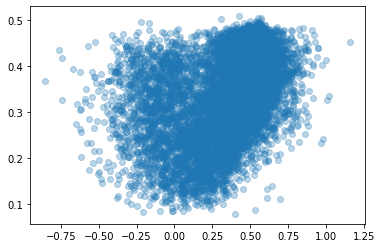

In [19]:
plt.scatter(y_test.values, y_pred, alpha=0.3)

# Visualizing for test

Ensure things work as expected using plots.

## Data augmentation

In [16]:
n_plot = 5
n_draw = 5

augmented_train_batches = (
    train_dataset
        .take(n_plot)
        .cache()
#         .shuffle(n_train // 4)
        .map(augment)
#         .batch(batch_size)
)

In [17]:
image, label = next(iter(train_dataset.batch(32)))

In [30]:
random_angles = tf.random.uniform(shape = (), minval=-np.pi, maxval=np.pi)
random_angles

<tf.Tensor: shape=(), dtype=float32, numpy=1.215853>

In [19]:
tf.__version__

'2.2.0-rc0'

In [ ]:
image = tfa.image.rotate(image, 1.215)

In [ ]:
augmented_train_batches.take(1).__iter__()

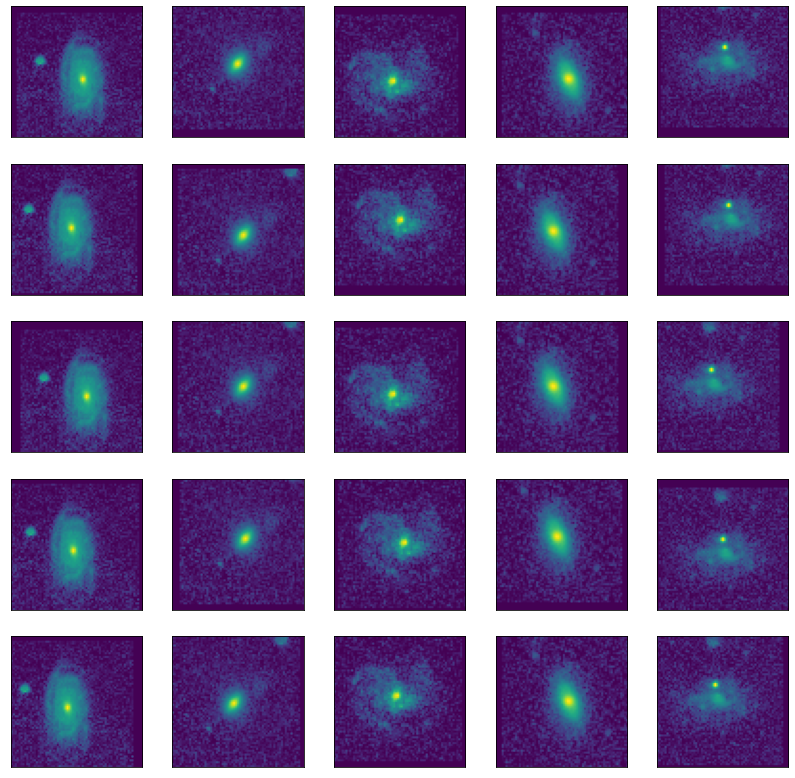

In [30]:
f, axarr = plt.subplots(n_plot, n_draw, figsize=(14, 14))
for i in range(n_draw):
    for j, (image, label) in enumerate(augmented_train_batches):
        image = image.numpy().squeeze()
        axarr[i, j].imshow(image)
        axarr[i, j].get_xaxis().set_visible(False)
        axarr[i, j].get_yaxis().set_visible(False)

# Testing / old

In [127]:
nepochs = 100
batch_size = 32
transformer = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=180, zoom_range=0.3,
                                horizontal_flip=True, vertical_flip=True)
# data_generator = transformer.flow(x_train, y_train.values, batch_size=batch_size)
ds = tf.data.Dataset.from_generator(
        transformer.flow, args=[x_train, y_train.values, batch_size],
        output_types=(tf.float32, tf.float32),
        output_shapes=([batch_size, npix, npix, 1], [bs])
)

In [ ]:
ds.cache()

In [70]:
nepochs = 100
bs = 64
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=180, zoom_range=0.3,
                                horizontal_flip=True, vertical_flip=True)
gen = datagen.flow(x_train, y_train.values, batch_size=bs)

In [82]:
a, b = next(gen)

In [119]:
a.shape

(64, 69, 69, 1)

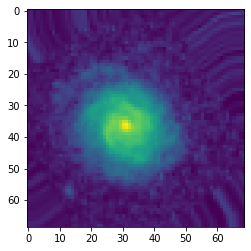

In [117]:
plt.imshow(datagen.random_transform(a[0, :]).squeeze())

In [ ]:
cnn.fit(x_train, y_train.values, validation_split=0.2, epochs=20,
        callbacks=callbacks)